# Exercise 06 CNN for Image Classification - Assignment

<span style="color:red">**The submission deadline of this assignment is 15/04/2024 23:59. In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained CNN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a multi-class image classification model using CNN.

The problem to be solved is to classify RGB images into one of the 10 pre-defined classes:

![](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a CNN-based image classifier
- Train the network, save and reload the best one
- Test and evaluation

### Import libraries

In [40]:
# [TBC] complete your code here with proper comments
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

## Task 1. Build the data pipeline

You are required to use the PyTorch built-in CIFAR10 dataset, consists of 60,000 $32\times32$ RGB images in 10 classes, with 6,000 images per class. You can find more information about this dataset from the [PyTorch documentation](https://www.tensorflow.org/datasets/catalog/cifar10) and the [original source](https://www.cs.toronto.edu/~kriz/cifar.html).

<span style="color:red">**[TBC]**</span> You need to:
- Use `torchvision.datasets.CIFAR10()` to load the CIFAR10 dataset
- Divide the dataset into the training, valiation, and test set
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [22]:
# [TBC] complete your code here with proper comments
# Load the CIFAR10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing the dataset
])

# Load the full dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [23]:
# Split the Dataset

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [30]:
#  Create DataLoader Instances

batch_size = 64  # Adjust based on your system capabilities

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [31]:
# Verify Everything is Correct

print(f"Training Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")


Training Set Size: 45000
Validation Set Size: 5000
Test Set Size: 10000


## Task 2. Create a CNN-based image classifier

<span style="color:red">**[TBC]**</span> You need to:
- Define a custom class to specify the structure of the network
    - You are required to use at least one convolutional layer in the network
- Specify the device used for computation
- Create an instance of the network and move it to the corresponding device

In [6]:
# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer taking 3 input channels (RGB), outputting 32 feature maps
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  # Output 10 classes

    def forward(self, x):
        # Apply convolutions, activation function and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the tensor
        x = x.view(-1, 128 * 4 * 4)
        # Fully connected layers with ReLU activation for hidden layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation, as this will be handled by the loss function
        return x


In [7]:
# Specify the Device for Computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
# Create an Instance of the Network and Move It to the Device
model = SimpleCNN().to(device)


In [9]:
# Check the Model Structure
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## Task 3. Train the network, save and reload the best one

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
    - Embed automatic model saving in the training process
    - <span style="color:red">**Don't forget to include the saved file in your submission.**</span>
- Train the network
    - Adjust the training hyper-parameters if necessary to get a good result
- Reload the best model after training
- Plot the loss history of the training process

In [35]:


# Define the train() Function


def train(model, train_loader, val_loader, num_epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # For plotting
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_path = 'best_CNN_IM.pth'

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Compute average loss
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses, best_model_path


In [36]:
# Train the model
num_epochs = 2
train_losses, val_losses, best_model_path = train(model, train_loader, val_loader, num_epochs)


Epoch 1, Train Loss: 0.8495, Validation Loss: 0.8428
Epoch 2, Train Loss: 0.6922, Validation Loss: 0.7914


In [37]:
# Reload the Best Model

best_model = SimpleCNN().to(device)
best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

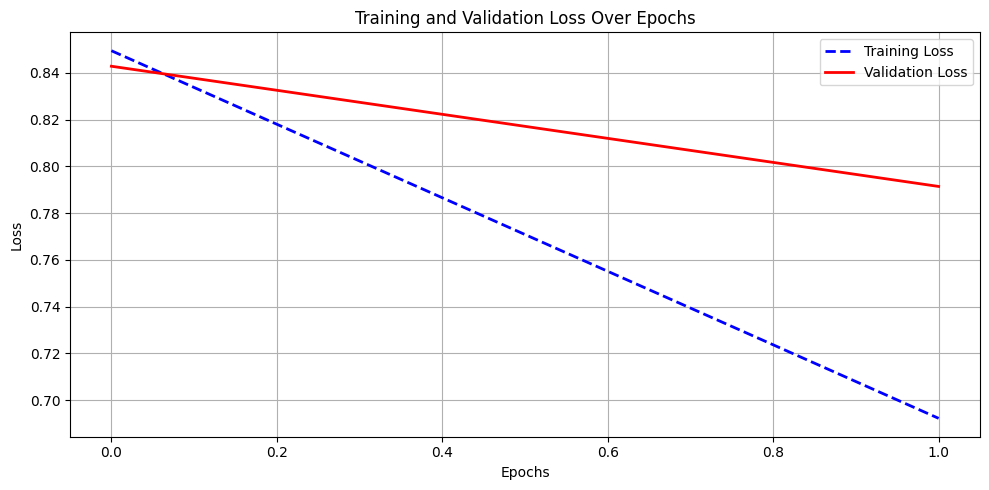

In [39]:
# Plot the Loss History with improvements
plt.figure(figsize=(10, 5))  # Set a larger figure size for better clarity
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2, linestyle='--')
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2, linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()


## Task 4. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [41]:
# Define the test() Function
def test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    all_logits = []
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Calculate probabilities and predictions
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Collect all necessary outputs for evaluation
            all_logits.append(logits)
            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(labels)

    # Convert lists to tensors
    all_logits = torch.cat(all_logits)
    all_probs = torch.cat(all_probs)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Calculate average loss
    average_loss = total_loss / len(test_loader)
    
    return all_logits, all_probs, all_preds, all_labels, average_loss

# Criterion for loss calculation
criterion = torch.nn.CrossEntropyLoss()

In [42]:
# Make Predictions on the Test Dataset

# Assuming test_loader is already defined and model is loaded
logits, probs, preds, labels, test_loss = test(best_model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.7778


In [44]:
# Define CIFAR-10 Class Names

CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


In [45]:
# Convert tensor to numpy for sklearn compatibility
preds_np = preds.cpu().numpy()
labels_np = labels.cpu().numpy()

# Generate classification report
report = classification_report(labels_np, preds_np, target_names=CIFAR10_CLASSES)  # CIFAR10_CLASSES is a list of class names
print(report)

              precision    recall  f1-score   support

    airplane       0.74      0.76      0.75      1000
  automobile       0.85      0.87      0.86      1000
        bird       0.60      0.66      0.63      1000
         cat       0.54      0.60      0.57      1000
        deer       0.68      0.71      0.69      1000
         dog       0.76      0.50      0.60      1000
        frog       0.84      0.77      0.80      1000
       horse       0.83      0.74      0.78      1000
        ship       0.73      0.90      0.81      1000
       truck       0.81      0.81      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000

